# 2. Physics Informed Neural Networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

# 2-1. Initial Value Problem (ODE)

Data is only obtained form an initial value

We will solve a simple system of ODEs 
$$
\frac{dy_1}{dt} = y_2, \quad  \frac{dy_2}{dt} = -y_1, \quad \text{for  } t \in [0,10] \\
\text{  with }\\
y_1(0) = 0, \quad y_2(0)=1,
$$
Then, the solutions are given by:
$$
y_1(t) = \sin(t), \quad y_2(t) = \cos(t)
$$

# Dataset generation

In [2]:
N = 100                                                   # Number of samples
t = torch.linspace(0, 10, N).view(-1,1)                   # Input data (N x 1)
t_init = torch.zeros([1,1])                               # Input data the initial conditions (1 x 1)
y_init = torch.FloatTensor([[0,1]])                       # Target data the initial conditions (1 x 2)
y_true = torch.cat([torch.sin(t), torch.cos(t)], dim=1)   # True solutions (N x 2)

# Neural Network

In [3]:
# Build a neural network

class model(nn.Module) :
    def __init__(self) :
        super(model, self).__init__()
        self.layer1 = nn.Linear(1,64)
        self.layer2 = nn.Linear(64,64)
        self.layer3 = nn.Linear(64,2) # 2nd_h_dim = 64, out_dim = 2
        self.act = nn.Tanh()

    def forward(self, x) :
        x = self.layer1(x)
        x = self.act(x)

        x = self.act(self.layer2(x))
        x = self.layer3(x)
        return x

# Loss function, Optimizer

In [8]:
# Prepare for training



# Compute $\frac{dy}{dt}$

In [4]:
t = t.requires_grad_(True) # The main difference compared to classical NN...
def der(y, t) :
    return torch.autograd.grad(y, t, create_graph=True, grad_outputs=torch.ones(y.size()))[0]

# Training

In [6]:
network = model()

loss_f = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=1e-3)
EPOCHS = 20000

In [ ]:
# Train
loss_list = []
network.train()

for i in range(1, EPOCHS+1) :
    optimizer.zero_grad()
    output = network(t)
    output_init = network(t_init)

    dy1 = der(output[:,0], t)
    dy2 = der(output[:,1], t)

    loss_init = loss_f(output_init, y_init)
    loss_ge = loss_f(dy1 - output[:,1].view(-1,1), torch.zeros_like(dy1)) \
            + loss_f(dy2 + output[:,0].view(-1,1), torch.zeros_like(dy1))

    loss = loss_init + loss_ge
    loss.backward()
    optimizer.step()

    loss_list.append(loss.item())
    if not i % 100 :
        print('EPOCH : %6d/%6d | Loss_init : %8.7f | Loss_ge : %8.7f ' %(i, EPOCHS, loss_init.item(), loss_ge.item()))
print('Training Finished.')

EPOCH :    100/ 20000 | Loss_init : 0.0021137 | Loss_ge : 0.0287245 
EPOCH :    200/ 20000 | Loss_init : 0.0016482 | Loss_ge : 0.0241428 
EPOCH :    300/ 20000 | Loss_init : 0.0012734 | Loss_ge : 0.0216280 
EPOCH :    400/ 20000 | Loss_init : 0.0010712 | Loss_ge : 0.0203291 
EPOCH :    500/ 20000 | Loss_init : 0.0009515 | Loss_ge : 0.0193152 
EPOCH :    600/ 20000 | Loss_init : 0.0008356 | Loss_ge : 0.0185318 
EPOCH :    700/ 20000 | Loss_init : 0.0007619 | Loss_ge : 0.0171731 
EPOCH :    800/ 20000 | Loss_init : 0.0006943 | Loss_ge : 0.0163700 
EPOCH :    900/ 20000 | Loss_init : 0.0006333 | Loss_ge : 0.0157911 
EPOCH :   1000/ 20000 | Loss_init : 0.0005910 | Loss_ge : 0.0153162 
EPOCH :   1100/ 20000 | Loss_init : 0.0005576 | Loss_ge : 0.0148620 
EPOCH :   1200/ 20000 | Loss_init : 0.0005317 | Loss_ge : 0.0144419 
EPOCH :   1300/ 20000 | Loss_init : 0.0004985 | Loss_ge : 0.0140618 
EPOCH :   1400/ 20000 | Loss_init : 0.0005042 | Loss_ge : 0.0139491 
EPOCH :   1500/ 20000 | Loss_init 

In [ ]:
#torch.save([network, loss_list], 'forward_ode.pt')
#network, loss_list = torch.load('forward_ode.pt')

# Plot Results

Mean Square Error for $y_1(t)$ : 0.0417005
Mean Square Error for $y_2(t)$ : 0.0499886


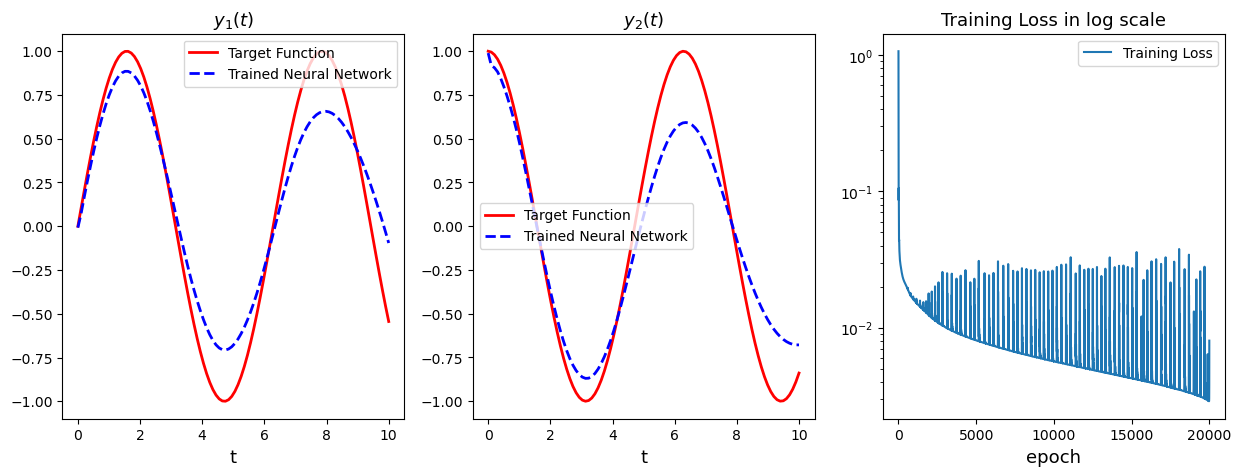

In [9]:
print('Mean Square Error for $y_1(t)$ : %8.7f' %((network(t)[:,0].view(-1,1) - torch.sin(t))**2).mean())
print('Mean Square Error for $y_2(t)$ : %8.7f' %((network(t)[:,1].view(-1,1) - torch.cos(t))**2).mean())

network.eval()
figure = plt.figure(figsize=(15,5))
ax1 = figure.add_subplot(1,3,1)
ax1.plot(t.cpu().detach().numpy(), torch.sin(t).cpu().detach().numpy(),\
         linestyle='-', lw=2, color='r', label='Target Function')
ax1.plot(t.cpu().detach().numpy(), network(t).cpu().detach().numpy()[:,0],\
         linestyle='--', lw=2, color='b', label='Trained Neural Network')
ax1.legend()
ax1.set_title('$y_1(t)$', fontsize=13)
ax1.set_xlabel('t', fontsize=13)

ax2 = figure.add_subplot(1,3,2)
ax2.plot(t.cpu().detach().numpy(), torch.cos(t).cpu().detach().numpy(),\
         linestyle='-', lw=2, color='r', label='Target Function')
ax2.plot(t.cpu().detach().numpy(), network(t).cpu().detach().numpy()[:,1],\
         linestyle='--', lw=2, color='b', label='Trained Neural Network')
ax2.legend()
ax2.set_title('$y_2(t)$', fontsize=13)
ax2.set_xlabel('t', fontsize=13)

ax3 = figure.add_subplot(1,3,3)
ax3.plot(loss_list, label='Training Loss')
ax3.set_yscale('log')
ax3.legend()
ax3.set_title('Training Loss in log scale', fontsize=13)
ax3.set_xlabel('epoch', fontsize=13)

plt.savefig('ode', dpi=100)

# 2-2. Initial Boundary Value Problem (PDE) ~ Skip
$$
\partial_t u + u\partial_x u = \nu \partial_{xx} u, \text{ for } (t,x) \in [0,1]\times[-1,1],
$$

with the Dirichlet boundary conditions $u(t,-1) = u(t,1) = 0, \text{ for } t \in [0,1]$

and an initial condition: $u(0, x) = -\sin(\pi x)$

# Dataset generation

In [ ]:
Nt = 50                                                   # Number of samples
Nx = 50                                                   # Number of samples
t = torch.linspace(0, 1, Nt)                              # Input data for t (N x 1)
x = torch.linspace(-1, 1, Nx)                             # Input data for x (N x 1)

tx = torch.meshgrid(t,x)
tx_grid = torch.cat([tx[0].reshape(-1,1), tx[1].reshape(-1,1)],dim=1)

x_init = tx_grid[tx_grid[:,0]==0]
u_init = -torch.sin(np.pi*x_init[:,1]).view(-1,1)
x_bdry = tx_grid[torch.logical_or((tx_grid[:,1]==1), (tx_grid[:,1]==-1))]
u_bdry = torch.zeros_like(x_bdry[:,0].view(-1,1))

In [ ]:
tx_grid.size()

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(tx_grid[:,0], tx_grid[:,1], 'co', markersize=3, label='uniform grid')
plt.plot(x_init[:,0], x_init[:,1], 'bo', markersize=3, label='initial points')
plt.plot(x_bdry[:,0], x_bdry[:,1], 'ro', markersize=3, label='boundary points')
plt.legend(loc='center right', fontsize=15)
plt.title('Uniform Grid', fontsize=15)
plt.xlabel('t', fontsize=15)
plt.ylabel('x', fontsize=15)
plt.savefig('burgers_data', dpi=100)

# Neural Network

In [ ]:
# Build a neural network ~ Another way to build NN

class model(nn.Module) :
    def __init__(self, hidden_dims) :                    # Hidden_dims : [h1, h2, h3, ..., hn]
        super(model, self).__init__()

        self.layers = []
        for i in range(len(hidden_dims)-1) :
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1])) # hidden layers
        self.layers = nn.ModuleList(self.layers)

        for layer in self.layers :                       # Weight initialization
            nn.init.xavier_uniform_(layer.weight)        # Also known as Glorot initialization

        self.act = nn.Tanh()                             # Nonlinear activation function

    def forward(self, x) :
        for layer in self.layers[:-1] :
            x = self.act(layer(x))
        x = self.layers[-1](x)
        return x

# Loss function, Optimizer

In [ ]:
# Prepare for training

network = model(hidden_dims=[2,64,64,64,64,1])
tx_grid = tx_grid.requires_grad_(True)
x_init = x_init
u_init = u_init
x_bdry = x_bdry
u_bdry = u_bdry

loss_f = nn.MSELoss()                                  # Mean Square Error loss function
optimizer = optim.Adam(network.parameters(), lr=1e-4)  # Adam optimizer
EPOCHS = 20000                                         # Number of Training Iterations

# Compute $\frac{\partial u}{\partial t}, \frac{\partial u}{\partial x}$

In [ ]:
def der(y, x) :
    return torch.autograd.grad(y, x, create_graph=True,\
                               grad_outputs=torch.ones(y.size()))[0]

# Training

In [ ]:
# Train
loss_list = []
network.train()

for i in range(1, EPOCHS+1) :
    optimizer.zero_grad()
    output = network(tx_grid)
    output_init = network(x_init)
    output_bdry = network(x_bdry)

    grad_output = der(output, tx_grid)  # \nabla_{t,x} u
    output_t = grad_output[:,0].view(-1,1)
    output_x = grad_output[:,1].view(-1,1)
    output_xx = der(grad_output[:,1], tx_grid)[:,1].view(-1,1)

    loss_init = loss_f(output_init, u_init)
    loss_bdry = loss_f(output_bdry, u_bdry)
    loss_ge = loss_f(output_t + output*output_x - (0.01/np.pi)*output_xx, torch.zeros_like(output))

    loss = loss_ge + loss_init + loss_bdry
    loss.backward()
    optimizer.step()

    loss_list.append(loss.item())
    if not i % 100 :
        print('EPOCH : %6d/%6d | Loss_ge : %8.7f | Loss_init : %8.7f | Loss_bdry : %8.7f' \
              %(i, EPOCHS, loss_ge.item(), loss_init.item(), loss_bdry.item()))
print('Training Finished.')

In [ ]:
#torch.save([network, loss_list], 'forward_Burgers.pt')
network, loss_list = torch.load('forward_Burgers.pt')

# Plot Results

In [ ]:
data = np.load('Burgers.npz')
lst = data.files

figure = plt.figure(figsize=(15,5))
ax1 = figure.add_subplot(1,3,1)
ax1.plot(np.linspace(-1,1,256), data['usol'][:,0],\
         label='True Solution at $t=0$', linestyle='-', lw=3, color='r')
ax1.plot(x_init[:,1].cpu(), network(x_init).cpu().detach(),\
         label='Neural Network at $t=0$', linestyle='--', lw=3, color='b')
ax1.legend()

ax2 = figure.add_subplot(1,3,2)
ax2.plot(np.linspace(-1,1,256), data['usol'][:,-1],\
         label='True Solution at $t=1$', linestyle='-', lw=3, color='r')
ax2.plot(tx_grid[tx_grid[:,0]==1][:,1].cpu().detach(), network(tx_grid[tx_grid[:,0]==1]).cpu().detach(),\
         label='Neural Network at $t=1$', linestyle='--', lw=3, color='b')
ax2.legend(loc='upper right', fontsize=10)
ax2.set_ylim(-1.1,1.1)

ax3 = figure.add_subplot(1,3,3)
ax3.plot(loss_list, label='Training Loss')
ax3.set_yscale('log')
ax3.legend()
ax3.set_title('Training Loss in log scale', fontsize=13)
ax3.set_xlabel('epoch', fontsize=13)
plt.savefig('burgers', dpi=100)

# 2-3. Parameter estimation (Lorenz system)


We will solve the Lorentz system : 
$$
\frac{dx}{dt} = \sigma(y-x),\quad \frac{dy}{dt} = x(\rho-z)-y,\quad \frac{dz}{dt} = xy - \beta z, \quad \text{for } t \in [0,3]
$$

with initial conditions:

$$
x(0)=-8, \quad y(0)=7, \quad z(0)=27.
$$


The parameters $\sigma=10, \rho=15, \beta=\frac{8}{3}$ will be identified from observations of the system.

# Dataset generation

In [ ]:
N = 100                                                  # Number of samples
t = torch.linspace(0, 3, N).view(-1,1)                   # Input data (N x 1)
t_init = torch.zeros([1,1])                              # Input data the initial conditions (1 x 1)
y_init = torch.FloatTensor([[-8, 7, 27]])                # Target data the initial conditions (1 x 2)

# Observations

In [ ]:
t_obs = np.array([0.        , 0.01071738, 0.06430429, 0.1226244 , 0.20389738,
        0.2774039 , 0.36605932, 0.46484636, 0.57747023, 0.74410941,
        0.87815709, 1.01220478, 1.15004686, 1.28280759, 1.42510765,
        1.58172756, 1.75397377, 1.89764233, 2.04923335, 2.18795955,
        2.37650218, 2.53747737, 2.69922368, 2.86424061, 3.        ])
t_obs = t_obs.reshape(-1,1)

In [ ]:
print(t_obs)

In [ ]:
y_obs = np.array([[-8.        ,  7.        , 27.        ],
       [-6.43173669,  7.79759441, 25.67505643],
       [-0.18252838,  8.79152601, 20.99658492],
       [ 3.57229135,  7.8080735 , 18.84537886],
       [ 5.36627   ,  6.04992857, 17.53854034],
       [ 5.35148452,  4.86286885, 16.37038521],
       [ 4.80410766,  4.21204751, 14.7105038 ],
       [ 4.43677847,  4.32840418, 12.97581442],
       [ 4.67479693,  5.19409195, 11.68338672],
       [ 6.10611558,  7.17187101, 12.03234314],
       [ 7.31176996,  7.84794249, 14.31934288],
       [ 7.19516841,  6.50968885, 16.07157003],
       [ 5.8841517 ,  4.90853799, 15.33987161],
       [ 4.98045591,  4.66005794, 13.55172674],
       [ 5.07979114,  5.50379208, 12.22259948],
       [ 6.13917344,  6.9487189 , 12.56718792],
       [ 7.12620686,  7.25485305, 14.78184719],
       [ 6.64255444,  5.94601342, 15.58157268],
       [ 5.56305455,  5.00705484, 14.43028767],
       [ 5.20087412,  5.24738741, 13.07585151],
       [ 5.91620229,  6.51374294, 12.72609034],
       [ 6.7730354 ,  7.09368059, 14.11026311],
       [ 6.66760163,  6.24642224, 15.19672982],
       [ 5.79518366,  5.32118749, 14.49148477],
       [ 5.43023844,  5.39174263, 13.43834563]])

In [ ]:
t_obs = torch.FloatTensor(t_obs)
y_obs = torch.FloatTensor(y_obs)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(-8,7,27, marker='*', s=100, color='r')
ax.plot(data['y'][:,0],data['y'][:,1],data['y'][:,2], 'b')
ax.plot(data['y'][:,0],data['y'][:,1],data['y'][:,2], 'bo')
plt.savefig('lorenz_data', dpi=100)

# Neural Network

In [ ]:
class model(nn.Module) :
    def __init__(self) :
        super(model, self).__init__()
        self.layer1 = nn.Linear(1,64)
        self.layer2 = nn.Linear(64,64)
        self.layer3 = nn.Linear(64,64)
        self.layer4 = nn.Linear(64,3) # 2nd_h_dim = 64, out_dim = 3 (x, y, z)
        self.act = nn.Tanh()

    def forward(self, x) :
        x = self.layer1(x)
        x = self.act(x)

        x = self.act(self.layer2(x))
        x = self.act(self.layer3(x))
        x = self.layer4(x)
        return x

# Loss function, Optimizer, Additional Parameters

In [ ]:
# Prepare for training

network = model()
t = t.requires_grad_(True)

sigma = torch.ones(1).requires_grad_(True)            # Parameter approximator
rho = torch.ones(1).requires_grad_(True)              # Parameter approximator
beta = torch.ones(1).requires_grad_(True)             # Parameter approximator

loss_f = nn.MSELoss()                                            # Mean Square Error loss function
optimizer = optim.Adam([{'params': network.parameters()},\
                        {'params': sigma, 'lr':1e-1}, {'params': rho, 'lr':1e-1},\
                        {'params': beta, 'lr':1e-1}], lr=1e-3)              # Adam optimizer
EPOCHS = 100000                                                   # Number of Training Iterations

# Compute $\frac{dy}{dt}$

In [ ]:
def der(y, t) :
    return torch.autograd.grad(y, t, create_graph=True,\
                               grad_outputs=torch.ones(y.size()))[0]

In [ ]:
# Train
loss_list = []
sigma_list, rho_list, beta_list = [], [], []
network.train()

for i in range(1, EPOCHS+1) :
    optimizer.zero_grad()
    output = network(t)
    output_init = network(t_init)
    output_obs = network(t_obs)

    dy1 = der(output[:,0], t).view(-1)
    dy2 = der(output[:,1], t).view(-1)
    dy3 = der(output[:,2], t).view(-1)

    loss_init = loss_f(output_init, y_init)
    loss_obs = loss_f(output_obs, y_obs)
    loss_ge = loss_f(dy1 - sigma*(output[:,1]-output[:,0]), torch.zeros_like(dy1)) +\
                loss_f(dy2 - output[:,0]*(rho-output[:,2]) + output[:,1], torch.zeros_like(dy2))+\
                loss_f(dy3 - output[:,0]*output[:,1] + beta*output[:,2], torch.zeros_like(dy3))

    loss = loss_ge + loss_init + loss_obs
    loss.backward()
    optimizer.step()

    loss_list.append(loss.item())
    sigma_list.append(sigma.item())
    rho_list.append(rho.item())
    beta_list.append(beta.item())

    if not i % 1000 :
        print('EPOCH : %6d/%6d | Loss_ge : %8.7f | Loss_init : %8.7f | Loss_obs : %8.7f' \
              %(i, EPOCHS, loss_ge.item(), loss_init.item(), loss_obs.item()))
print('Training Finished.')

In [ ]:
#torch.save([network, sigma_list, rho_list, beta_list], 'Lorenz.pt')
#network, sigma_list, rho_list, beta_list = torch.load('Lorenz.pt', map_location=device)

In [ ]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(-8,7,27, marker='*', s=100, color='r')
ax.plot(data['y'][:,0], data['y'][:,1], data['y'][:,2], 'b')
ax.plot(data['y'][:,0], data['y'][:,1], data['y'][:,2], 'bo')
ax.set_title('Reference Solution', fontsize=15)

ax = fig.add_subplot(122, projection='3d')
ax.scatter(-8,7,27, marker='*', s=100, color='r')
prediction = network(t).cpu().detach()
ax.plot(prediction[:,0], prediction[:,1], prediction[:,2], 'b')
#ax.plot(prediction[:,0], prediction[:,1], prediction[:,2], 'bo')
ax.set_title('Trained Neural Network Solution', fontsize=15)
plt.savefig('lorenz', dpi=100)

In [ ]:
figure = plt.figure(figsize=(15,5))
ax1 = figure.add_subplot(1,3,1)
ax1.plot(sigma_list)
ax1.set_title('$\sigma$')
ax1.set_xlabel('epoch')
ax1.hlines(10, 0, 100000, label='True $\sigma$')

ax2 = figure.add_subplot(1,3,2)
ax2.plot(rho_list)
ax2.set_title('$\\rho$')
ax2.set_xlabel('epoch')
ax2.hlines(15, 0, 100000, label='True $\\rho$')

ax3 = figure.add_subplot(1,3,3)
ax3.plot(beta_list)
ax3.set_title('$\\beta$')
ax3.set_xlabel('epoch')
ax3.hlines(8/3, 0, 100000, label='True $\\beta$')
plt.savefig('lorenz2', dpi=100)